# Notebook to test and illustrate FAST algorithm

In [1]:
%load_ext autoreload
%autoreload 2

### Tests on single image

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import fast
import opticalFlow

### global params

In [3]:
TRAIN_FRAMES_FOR_KP_DETECTION = 10

START_IDX = 60
if START_IDX - TRAIN_FRAMES_FOR_KP_DETECTION <= 0:
    START_IDX = TRAIN_FRAMES_FOR_KP_DETECTION + 1
END_IDX = 200
nb_keypoints = 100

result_gif = 'imgs/person_dog_opticalFlow_opencv.gif'
skip = 1

### cv2 params

In [4]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = nb_keypoints,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Take first frame and find corners in it
cap = cv2.VideoCapture("imgs/person_dog.mp4")
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

### added params

In [5]:
START_IDX_KP = START_IDX - TRAIN_FRAMES_FOR_KP_DETECTION
END_IDX_KP = START_IDX - 1

cols = 4
rows = 3

print(f"Train kp from {START_IDX_KP} to {END_IDX_KP}")

Train kp from 50 to 59


### Get KP

Number of final keypoints: 249


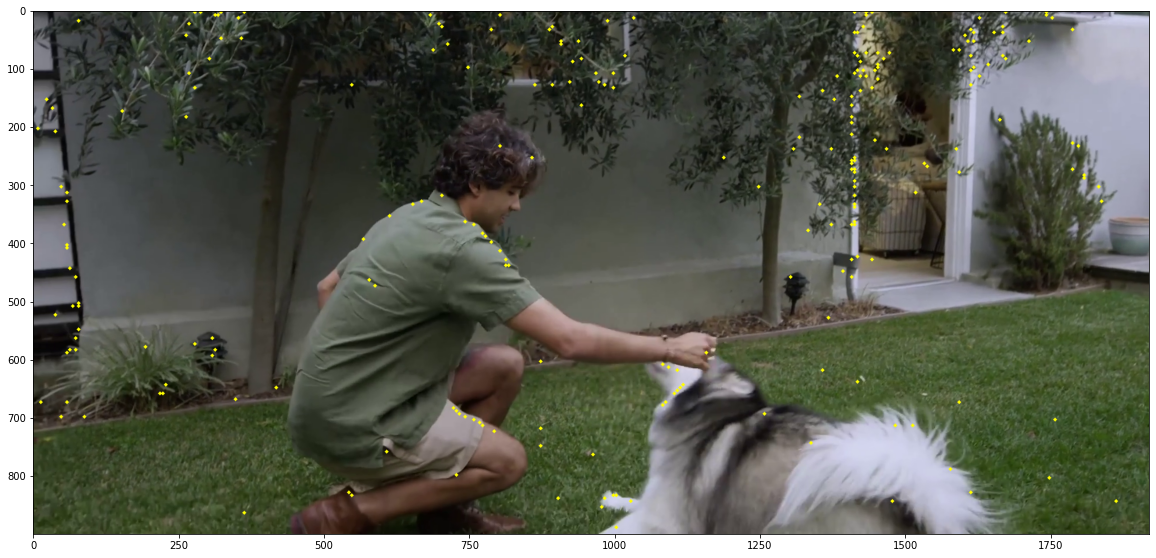

In [6]:
IDX_KP = 0

cap = cv2.VideoCapture("imgs/person_dog.mp4")
ret, frame = cap.read()

while ret:
    if START_IDX_KP <= IDX_KP < END_IDX_KP:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints = fast.detect_with_adaptive_threshold_and_grid(
            gray, nb_keypoints, N=12, step=5, epsilon=nb_keypoints*0.1,
            percentage=0.10, init_thresholds=None, rows=rows, cols=cols)
    elif IDX_KP >= END_IDX_KP:
        break
    ret, frame = cap.read()
    IDX_KP += 1
    print(f'IDX={IDX_KP}', end='\r')

img_with_kp = fast.draw(frame, keypoints)
#cv2.imwrite("imgs/person_dog_kp_detector.png", img_with_kp)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

keypoints = np.expand_dims(keypoints, axis=1).astype(np.float32)
print(f"Number of final keypoints: {keypoints.shape[0]}")

### comparison fast and cv2.goodFeaturesToTrack

In [7]:
nb_keypoints = keypoints.shape[0]
# Create some random colors
color = np.random.randint(0, 255, (nb_keypoints,3))

# test Optical flow opencv

In [8]:
cap = cv2.VideoCapture("imgs/person_dog.mp4")
IDX = 0
imgs = []

kp_to_use = np.flip(keypoints.copy())

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    if IDX % skip != 0:
        IDX += 1
        continue
    if START_IDX <= IDX < END_IDX:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, kp_to_use, None, **lk_params)
        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = kp_to_use[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new, good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        kp_to_use = good_new.reshape(-1,1,2)
        imgs.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
    elif IDX >= END_IDX:
        break
    IDX += 1
    print(f'IDX={IDX}', end='\r')

imgs[0].save(result_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)
    
cap.release()
cv2.destroyAllWindows()